## E03 Predict water features given model
#### 0. Load required libraries, site dependant constants and utility functions.

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns
import joblib
from sklearn import metrics

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

#### 1. Load model

In [2]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './LGBMClassifier_model_20000_unbalanced_WATER_only_MODIS_test_0_fixed_lr_01_min_wat_50.pkl'
model = joblib.load(model_path)

# predict the test labels
#plabels_test = model.predict(features_test)

#### 2. Define EOTask

In [15]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = ftrs.reshape(t * w * h, f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(t, w, h )
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK, self.predicted_labels_name, plabels)
        
        #if self.predicted_scores_name:
        #    pscores = self.model.predict_proba(ftrs)
        #    _, d = pscores.shape
        #    pscores = pscores.reshape(w, h, d)
        #    eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return plabels

In [16]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET'), 'PREDICTED_WATER_FEATURES', predicted_scores_name ='predicted_scores_name')

#### 3. Check out EOTask:

In [17]:
file = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[0], site.SITE_NAME, site.AVAILABLE_CRSs[0], site.DATE_RANGES_MODIS[0])
eo_patch = io_utils.load_exemplary_eopatch_from_file(file)

Loaded from ../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2013_04-2013_11/3313_maxcc_0.05_x-6_y-137


In [18]:
predict_patch.execute(eo_patch)

array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [19]:
eo_patch

EOPatch(
  data: {
    DATASET: numpy.ndarray(shape=(194, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 7), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
    PREDICTED_WATER_FEATURES: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
    DEM_SLOPE_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 6
    index_y: 137
    maxcc: '0.05'
    patch_index: 3313
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
 

2013-08-03 12:00:00
Ploting...


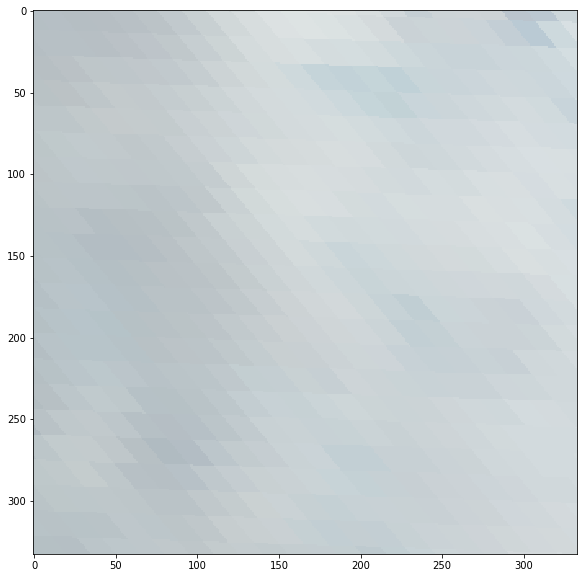

In [35]:
plot_utils.plot_RGB_MODIS_image(eo_patch, datetime_idx=99)

2013-08-04 12:00:00
Ploting...


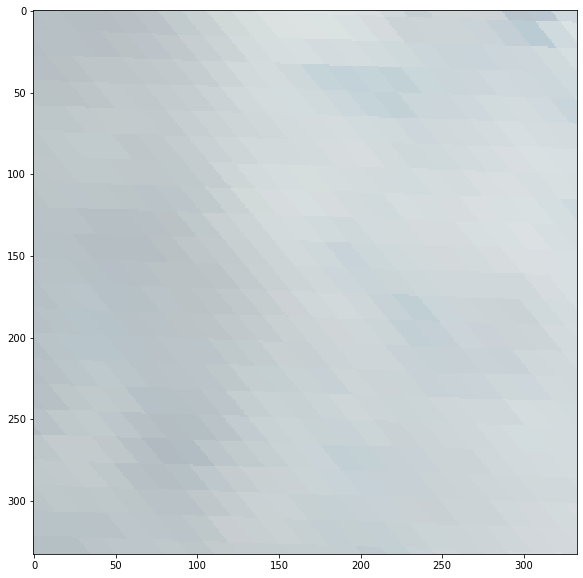

In [37]:
plot_utils.plot_RGB_MODIS_image(eo_patch, datetime_idx=100)

In [24]:
data = eo_patch.mask['PREDICTED_WATER_FEATURES']

In [25]:
data.shape

(194, 333, 333, 1)

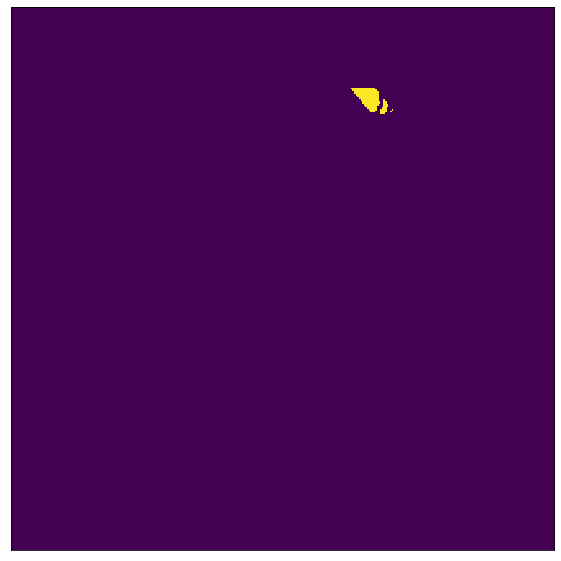

In [36]:
plot_utils.plot_matrix(data[99])

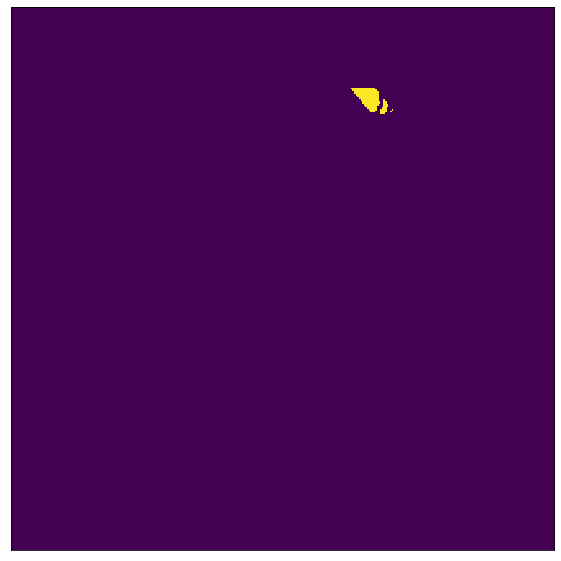

In [38]:
plot_utils.plot_matrix(data[100])

In [40]:
class CountMaskCoverage(EOTask):
    
    def __init__(self, input_mask_name, output_scalar_name ):
        self.input_mask_name = input_mask_name
        self.output_scalar_name = output_scalar_name
        
    def execute(self, eopatch):
        ultimate_masks = eopatch.mask[self.input_mask_name]
        mask_shape = ultimate_masks.shape
        #print(mask_shape)
        coverage_list = []
        
        for i in range(mask_shape[0]):
            array = ultimate_masks[i].squeeze()
            #print(array.shape)
            coverage = np.sum(array.astype(np.uint8)) #/ np.prod(array.shape)
            coverage_list.append(coverage)
        
        
        eopatch.add_feature(FeatureType.SCALAR_TIMELESS, self.output_scalar_name, np.asarray(coverage_list))
        return eopatch

In [41]:
calculate_water_mask_coverage = CountMaskCoverage(input_mask_name='PREDICTED_WATER_FEATURES',
                                                            output_scalar_name='PREDICTED_WATER_MASK_COVERAGE')

In [42]:
calculate_water_mask_coverage.execute(eo_patch)

EOPatch(
  data: {
    DATASET: numpy.ndarray(shape=(194, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 7), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
    PREDICTED_WATER_FEATURES: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
    DEM_SLOPE_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {
    PREDICTED_WATER_MASK_COVERAGE: numpy.ndarray(shape=(194,), dtype=uint32)
  }
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 6
    index_y: 137
    maxcc: '0.05'
    patch_inde

In [43]:
eo_patch.scalar_timeless['PREDICTED_WATER_MASK_COVERAGE']

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  561,
          0,    0,    0,   20,   15,   12,  191,  100,  100,  249,  681,
        644,  324,  220,  236,  337,  244,  360,  373,  398,  355,  269,
        241, 1253,  195,  176,  141,   83,  236, 1045,  462,  462,  698,
        508,  448,  320,   24,    0,    0,    0,    0,   51,   51,    0,
        189,  189,    0,    0,    0,  171,  171,    0,    8,    0,    0,
        242,    7,   80,   67,  269,   67,   80,    0,    0,    0,    1,
          0,   19,   19,    0,  166,    0,    0,    0,  706,  221,  333,
        580,  621,    0,  155,  822,    0,    0,    0,  367,  393,  687,
         31,    0,   88,  159,   75,  283,   19,   

#### 2. Create and execute EOWorkflow

In [ ]:
%%time
# application dataset building eotasks for all aval eopatches in the a eoworkflow
for date_range_modis in site.DATE_RANGES_MODIS:
    print('Reading EOPatches from:', date_range_modis)
    eopatches_filepath = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[0], site.SITE_NAME, site.AVAILABLE_CRSs[0], date_range_modis)
    # TASK TO LOAD AND SAVE EXISTING EOPATCHES HAS TO BE CREATED YEARLY (different directories)
    load_eotask = LoadTask(eopatches_filepath)
    save_eotask = SaveTask(eopatches_filepath, overwrite_permission=OverwritePermission.OVERWRITE_PATCH, compress_level=1)
    
    # Define the workflow
    workflow = LinearWorkflow(
    load_eotask,
    predict_patch,
    calculate_water_mask_coverage,
    save_eotask
    )
                      
    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    execution_args = []
    for eopatch_name in list_of_available_patches:
        execution_args.append({
        load_eotask: {'eopatch_folder': eopatch_name},
        save_eotask: {'eopatch_folder': eopatch_name}
        })
    
    #print(execution_args)                            
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=1, multiprocess=False)

    executor.make_report()

Reading EOPatches from: ('2013-04-26', '2013-11-05')
